In [62]:
import sys
sys.path.append('./../')

In [63]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import importlib
from statsmodels.nonparametric.kde import KDEUnivariate
from collections import Counter
import pandas as pd

In [64]:
import optim as opt
import helpertests as tst
import sparsedense as spd

In [65]:
test = 'arxiv'

In [66]:
links = np.genfromtxt('{}.tsv'.format(test), delimiter='\t', dtype=int)
g = nx.Graph()
g.add_edges_from(links)
net = nx.adjacency_matrix(g).toarray().astype(int)
for i in range(net.shape[0]):
    net[i, i] = 1
    

In [67]:
with open('{}_clique_init.pkl'.format(test), 'rb') as f:
    runs = pickle.load(f)

In [68]:
alpha, sigma, c, num_cliques = runs['alphas'][-1], runs['sigmas'][-1], runs['cs'][-1], runs['Ks'][-1]
alpha, sigma, c, num_cliques

(2.825334687452128, 0.29217817544997615, 799.7654088474519, 3898)

In [69]:
def gen_rcc_samples(nreps, alpha, sigma, c, num_cliques):
    for k in range(nreps):
        Z = opt.sample_from_ibp(num_cliques, alpha=alpha, sigma=sigma, c=c)
        net = Z.transpose() @ Z
        K, N = Z.shape
        links = []
        for i in range(N - 1):
            for j in range(i + 1, N):
                if net[i, j] >= 1:
                    links.append([i, j])
        np.savetxt('rcc_runs_clique_init/{}.tsv'.format(k), np.array(links), delimiter='\t', fmt='%d')

In [70]:
nreps = 5
gen_rcc_samples(nreps, alpha, sigma, c, num_cliques)

In [71]:
def test_samples(path, n=25, mc_size=500, verbose=True, offset=0):
    
    num_nodes, num_edges, edge_node, density, deg, max_clique_node, clust_coeff, conn_comp_largest, short_paths = [], [], [], [], [], [], [], [], []

    for i in range(n):
        links = np.genfromtxt(path + '{}.tsv'.format(i+offset), delimiter='\t', dtype=int)
        g = nx.Graph()
        g.add_edges_from(links - 1)

        num_nodes_i, num_edges_i, edge_node_ratio_i, density_i, deg_i, max_clique_node_i, clust_coeff_i, conn_comp_i, short_paths_i = \
            tst.test_stats(g, mc_size=mc_size, verbose=False, return_results=True)

        num_nodes.append(num_nodes_i)
        num_edges.append(num_edges_i)
        edge_node.append(edge_node_ratio_i)
        density.append(density_i)
        deg.append(deg_i)
        max_clique_node.append(max_clique_node_i)
        clust_coeff.append(clust_coeff_i)
        conn_comp_largest.append(conn_comp_i / num_nodes_i)
        short_paths.append(short_paths_i)

    if verbose:
        print("- num nodes: {:f}, {:f}".format(np.mean(num_nodes), np.std(num_nodes)))
        print("- num edges: {:f}, {:f}".format(np.mean(num_edges), np.std(num_edges)))
        print("- edge node ratio: {:2.2f}, {:f}".format(np.mean(edge_node), np.std(edge_node)))
        print("- density: {:2.6f}, {:f}".format(np.mean(density), np.std(density)))
        print("- mean degree: {:2.2f}, {:f}".format(np.mean(deg), np.std(deg)))
        print("- mean maximal clique containing node: {:2.2f}, {:f}".format(np.mean(max_clique_node), np.std(max_clique_node)))
        print("- clustering coefficient: {:2.2f}, {:f}".format(np.mean(clust_coeff), np.std(clust_coeff)))
        print("- connected component sizes (largest): {}, {:f}".format(np.mean(conn_comp_largest), np.std(conn_comp_largest)))
        print("- mean distance between nodes (largest conn. comp.): {:2.2f}, {:f}".format(np.mean(short_paths), np.std(short_paths)))  

In [72]:
tst.test_stats(g)

- num nodes: 5241
- num edges: 14484
- edge node ratio: 2.76
- density: 0.001055
- mean degree: 5.53
- mean maximal clique containing node: 4.77
- clustering coefficient: 0.54
- connected component sizes (top 5): [4158, 14, 12, 10, 9]
- mean distance between nodes (largest conn. comp.): 6.07


In [73]:
test_samples('rcc_runs_clique_init/',n=5)

- num nodes: 5016.600000, 24.711131
- num edges: 15189.400000, 587.311365
- edge node ratio: 3.03, 0.110651
- density: 0.001207, 0.000042
- mean degree: 6.06, 0.221301
- mean maximal clique containing node: 4.55, 0.052466
- clustering coefficient: 0.63, 0.022881
- connected component sizes (largest): 0.9412908388363184, 0.006286
- mean distance between nodes (largest conn. comp.): 4.65, 0.118791


In [74]:
test_samples('bnpgraph_runs/arxiv_', offset=1,n=5)

- num nodes: 5231.200000, 50.803150
- num edges: 14674.200000, 506.717041
- edge node ratio: 2.80, 0.081100
- density: 0.001072, 0.000028
- mean degree: 5.61, 0.162200
- mean maximal clique containing node: 2.11, 0.006928
- clustering coefficient: 0.00, 0.001054
- connected component sizes (largest): 0.9828934630326025, 0.003461
- mean distance between nodes (largest conn. comp.): 4.44, 0.028074


In [75]:
def fit_kde(x, grid):
    resol = len(grid)
    d = np.zeros(resol)
    kde = KDEUnivariate(x)
    kde.fit()
    d = kde.evaluate(grid)    
    return d

def fit_count(x, grid):
    cnt = Counter(x)
    d = np.array([cnt[y] for y in grid]) / len(x)
    return d

def degree_clique_density_runs(path, deg_grid, clique_grid, n = 25, offset=0):
    deg_dens = np.zeros(len(deg_grid))
    clique_dens = np.zeros(len(clique_grid))
    
    for k in range(n):
        links = np.genfromtxt(path + '{}.tsv'.format(k + offset), delimiter='\t', dtype=int)
        g = nx.Graph()
        g.add_edges_from(links - 1)


        degs = np.array([nx.degree(g, i) for i in g.nodes()], dtype=float)
        clique = np.array([nx.node_clique_number(g, i) for i in g.nodes()], dtype=float)
        
        deg_dens += fit_kde(degs, deg_grid) / n  
        clique_dens += fit_count(clique, clique_grid) / n  
        
    return deg_dens, clique_dens

def degree_clique_density_graph(g, deg_grid, clique_grid):
    degs = np.array([nx.degree(g, i) for i in g.nodes()], dtype=float)
    clique = np.array([nx.node_clique_number(g, i) for i in g.nodes()], dtype=float)

    deg_dens = fit_kde(degs, deg_grid)
    clique_dens = fit_count(clique, clique_grid) 
        
    return deg_dens, clique_dens

In [105]:
deg_grid = np.linspace(1, 25, 20)
clique_grid = np.arange(2, 20)

deg_dens_rcc, clique_dens_rcc = degree_clique_density_runs('rcc_runs_clique_init/', deg_grid, clique_grid)
deg_dens_bnp, clique_dens_bnp = degree_clique_density_runs('bnpgraph_runs/arxiv_', deg_grid, clique_grid, offset=1)

In [106]:
deg_dens_orig, clique_dens_orig = degree_clique_density_graph(g, deg_grid, clique_grid)

KeyboardInterrupt: 

In [ ]:
deg_df = pd.DataFrame({
    'Truth': deg_dens_orig, 
    'RCC': deg_dens_rcc, 
    'BNPGraph': deg_dens_bnp}, index=deg_grid)
maxclique_df = pd.DataFrame({
    'Truth': clique_dens_orig, 
    'RCC': clique_dens_rcc,
    'BNPGraph': clique_dens_bnp}, index=clique_grid)

In [ ]:
style = ['b--','r-','c-.']
deg_df.plot(style=style, markersize=5, linewidth=2, figsize = (6, 4))
plt.legend(fontsize=14) # using a size in points
plt.xlim(1, 45)
plt.xlabel("Degree", fontsize=14)
# plt.ylabel("Density")
# plt.title("Degree distribution")
plt.savefig('arxiv_clique_init_degree_dist.png', format="PNG")
plt.show()

In [ ]:
# style = ['b--','r-','c-.']
# maxclique_df.plot(style=style, markersize=5, linewidth=2, figsize = (6, 4))
# plt.legend(fontsize=14) # using a size in points
# plt.xlim(2, 15)
# plt.xlabel("Maximal clique size per node", fontsize=14)
# # plt.ylabel("Density")
# # plt.title("Degree distribution")
# plt.savefig('arxiv_clique_init_maximal_clique_dist.png', format="PNG")
# plt.show()

In [81]:
def fit_count(x, grid):
    cnt = Counter(x)
    d = np.array([cnt[y] for y in grid]) / len(x)
    return d

def clique_density_runs(path, clique_grid, n = 25, offset=0):
    counts = np.zeros((len(clique_grid), n))
    
    for k in range(n):
        links = np.genfromtxt(path + '{}.tsv'.format(k + offset), delimiter='\t', dtype=int)
        g = nx.Graph()
        g.add_edges_from(links - 1)

        clique = np.array([nx.node_clique_number(g, i) for i in g.nodes()], dtype=float)    
        counts[:,k] = fit_count(clique, clique_grid)
    
    means = np.mean(counts, 1)
    std = np.std(counts, 1)
        
    return means, std

def clique_density_graph(g, clique_grid, n = 25, offset=0):
    clique = [nx.node_clique_number(g, i) for i in g.nodes()]
    counts = fit_count(clique, clique_grid)
    
    return counts

In [85]:
clique_grid = np.arange(2, 10)
clique_means_rcc, clique_std_rcc = clique_density_runs('rcc_runs_clique_init/', clique_grid)
clique_means_bnp, clique_std_bnp = clique_density_runs('bnpgraph_runs/arxiv_', clique_grid, offset=1)
clique = clique_density_graph(g, clique_grid)
df = pd.DataFrame({'Truth': clique, 'RCC': clique_means_rcc, 'BNPGraph': clique_means_bnp}, index=clique_grid)

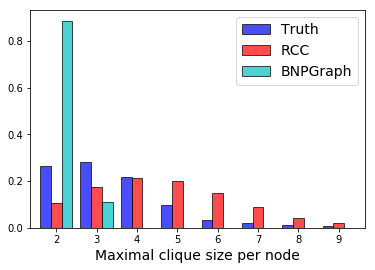

In [109]:
style = ['b','r','c']
df.plot.bar(width=.8, figsize=(6,4), alpha=0.7, rot=0, color=style, edgecolor = 'black')
plt.legend(fontsize=14)
plt.xlabel('Maximal clique size per node', fontsize=14)
plt.savefig('arxiv_clique_init_maximal_clique_dist.png', format="PNG")